# Question 2. IWAL algorithm implementation (50 points)

The purpose of this question is to implement Importance Weighted Active Learning (IWAL) algorithm. For this question, you will not use modAL, but instead will implement IWAL routine from scratch using scikit-learn, NumPy and native Python. 

In this question, we will use a simple synthetic dataset for a binary classification problem. Each data point has only 2 features. The dataset is provided in 2 files -- “data_iwal.npy”, which contains features and “labels_iwal.npy”, which contains labels. 

For simplicity, you will implement bootstrapping rejection sampling subroutine with logistic regression and hinge loss.   

𝐂𝐨𝐦𝐩𝐥𝐞𝐭𝐞 𝐭𝐡𝐞 𝐜𝐨𝐝𝐞 𝐮𝐧𝐝𝐞𝐫 ###𝐓𝐎 𝐃𝐎 𝐢𝐧 𝐞𝐚𝐜𝐡 𝐜𝐞𝐥𝐥 𝐚𝐧𝐝 𝐩𝐫𝐨𝐝𝐮𝐜𝐞 𝐭𝐡𝐞 𝐫𝐞𝐪𝐮𝐢𝐫𝐞𝐝 𝐩𝐥𝐨𝐭𝐬.  Feel free to define any helper functions as you see fit. You may import and use any modules in scikit-learn and NumPy to help with your implementations.

## Imports

Here we import necessary modules. Feel free to add something else here if you need it!

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import hinge_loss, log_loss
from sklearn.linear_model import LogisticRegression

## Reading data

Here we read the data and split it into train and test datasets. Train will be used to train our classification model and test will be used to validate the performance, monitor overfitting and compare the results of the model trained with Active Learning with the ones of the model trained from scratch. We set aside 1/3 of the dataset for validation.

In [2]:
X = np.load("data/q2/data_iwal.npy")
y = np.load("data/q2/labels_iwal.npy")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(X[0:2])
print(y[0:2])

(134, 2)
(134,)
(66, 2)
(66,)
[[2.59193175 1.14706863]
 [1.7756532  1.15670278]]
[1 1]


## Part 2.1
Type your answers for the theoretical questions below.

1. What is the idea behind IWAL algorithm?

**Your answer goes here**
Corrects for sample bias using weighting.


2. What are the assumptions made for the IWAL algorithm?

**Your answer goes here**

3. What are the pros and cons of IWAL algorithm?

**Your answer goes here**

## Part 2.2 Implement IWAL algorithm

In this part you will implement a function that performs a single query of Algorithm 1 IWAL (subroutine rejection-sampling) from the paper. Below is the function description that you can follow in your implementation.

### Implemented Equations

$h_t = \underset{h \in H}{argmin}\sum_{(x,y,c)\in S_t}c \cdot l(h(x),y)$

In [5]:
# implemented in custom Python package iwal_functions

## Part 2.3 Implement bootstrapping rejection sampling subroutine
In this part you will implement bootstrapping rejection sampling subroutine from the paper, section 7.2

### Implemented Equations
$p_t = p_{min}+(1-p_{min})[\underset{y;h_i,h_j \in H}{max}L(h_i(x),y)-L(h_j(x),y)]$

where $p_{min}$ is a lower bound on the sampling probability

In [6]:
# implemented in custom Python package iwal_functions

## Part 2.4 Organize all implemented parts into a single pipeline
You implemented all parts of the IWAL algorithm with bootstrap rejection sampling. Now organize it into a pipeline.

In [11]:
%%time

#?? try implementing only the max difference as a normalized value

from packages.iwal import iwal  # my custom package

# fill hypothesis_space
H = []
num_h = 10
for i in range(num_h):
    lr = LogisticRegression()
    H.append(lr)

# additional arguments
bootstrap_size = 10
labels = [0,1]
p_min = 0.1  
history = {'X': [],'y': [],'c': [],'Q': []}
selected = []
rejection_threshold = 'bootstrap'

# Perform queries and record loss
losses = []
n_query = 60 # first 10 queries are bootstrapping process
for t in range(n_query):
    
    # select sample 
    x_t = X_train[t].reshape(1,2)
    y_t = y_train[t].reshape(1,)
    
    # select optimal hypothesis
    h_t = iwal.iwal_query(x_t,y_t,H,history,selected,labels,rejection_threshold,bootstrap_size,p_min)

    # calculate loss only for fitted models
    if h_t:

        # calculate loss and store for later
        loss_t = log_loss(y_test, h_t.predict_proba(X_test)) 
        losses.append(loss_t)
     

CPU times: user 10 s, sys: 58.1 ms, total: 10.1 s
Wall time: 10.1 s


In [8]:
# for t in range(n_query):
#     print('X:', history['X'][t],'y:',history['y'][t],'c:',history['c'][t],'Q:',history['Q'][t])

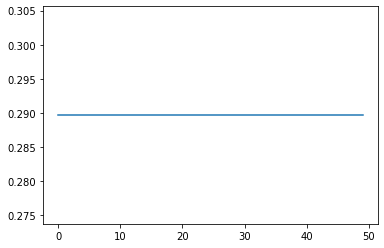

In [12]:
plt.plot(losses)

## Part 2.5 Compare results of Active Learning vs No Active Learning

In this part you need to create object of the same scikit learning class and train it on randomly selected subset of data points and compare results of 2 classifiers. Comment on your observations

In [13]:
# Compare to no Active Learning setting
# ?? how much data to train it on? same as A.L.?

## TODO: your code goes here
# select random training set
X_rand= X_train[:n_query]
y_rand = y_train[:n_query]

# train model
lr = LogisticRegression()
lr.fit(X_rand, y_rand)

offline_loss = log_loss(y_test, lr.predict_proba(X_test)) 

print('Active Learning loss:', losses[-1])
print('Offline loss (no active learning):',offline_loss)

Active Learning loss: 0.2896872768798825
Offline loss (no active learning): 0.048533554284791405


### Comment on observations
It appears that offline loss is less than active learning loss for a small sample size.